## Credit Card Kaggle Anamoly Detection

### Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

### Content
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

### Inspiration
Identify fraudulent credit card transactions.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

### Acknowledgements
The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project

###  Introduction 
In this notebook we will use various predictive models to see how accurate they  are in detecting whether a transaction is a normal payment or a fraud. As described in the dataset, the features are scaled and the names of the features are not shown due to privacy reasons. Nevertheless, we can still analyze some important aspects of the dataset. Let's start!

In [1]:
# Importing the libraries

import warnings 
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.gridspec as gridspec

from collections import Counter

import plotly.offline as py
py.init_notebook_mode(connected=True)

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import classification_report,accuracy_score, roc_curve, precision_score
from sklearn.metrics import confusion_matrix, recall_score, roc_auc_score, f1_score, precision_recall_curve
from sklearn.model_selection import cross_val_score
from imblearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

In [2]:
data = pd.read_csv('creditcard.csv')

In [3]:
data.shape

(284807, 31)

In [4]:
data.head().style.set_properties(**{"background-color":"black","color":"lawngreen"})

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.620000,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.690000,0
2,1.000000,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.660000,0
3,1.000000,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.500000,0
4,2.000000,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.990000,0


### <h3><font color=red>OBSERVATIONS</font></h3>

&#9658; **Due to confidentiality issue, original features V1, V2,... V28 have been transformed using PCA, however, my guess is that these features might be credit card number, expiry date, CVV, cardholder name, transaction location, transaction date-time, etc.**

&#9658; **Only features which have not been transformed with PCA are 'Time', 'Amount' and 'Class'.**<br>

> &#9678; **'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset.**<br><br>
> &#9678; **The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning.**<br><br>
> &#9678; **The Feature 'Class' is the response or target variable and it takes value 1 in case of fraud and 0 otherwise.**<br>

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

&#9658; **We can clearly see that we don't have any null values in the data which is bound to happen in such datasets as each and every information is very necessary else the transaction isn't processed.**

In [6]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

## <font color=red>Descriptive Statistics</font>

&#9658; **As most of the columns V1, V2,... V28 are transformed using PCA so neither features make much sense and nor will the descriptive statistics so we will leave them and consider only Time and Amount which makes sense.**

In [7]:
data[['Time','Amount']].describe().style.set_properties(**{"background-color":"black","color":"yellow"})

,Time,Amount
count,284807.000000,284807.000000
mean,94813.859575,88.349619
std,47488.145955,250.120109
min,0.000000,0.000000
25%,54201.500000,5.600000
50%,84692.000000,22.000000
75%,139320.500000,77.165000
max,172792.000000,25691.160000


## <font color=red>OBSERVATIONS</font>

&#9658; **Mean transaction is somewhere is 88 and standard deviation is around 250.**<br><br>
&#9658; **The median is 22 which is very less as compared to mean which signifies that there are outliers or our data is highly positive skewed which is effecting the amount and thus the mean.**<br><br>
&#9658; **The maximum transaction that was done is of 25,691 and minimum is 0.**


In [8]:
##Differentiating the Fraud and the Normal Dataset

fraud = data[data['Class']==1]
normal = data[data['Class']==0]
outlier_fraction = len(fraud)/float(len(normal))

In [9]:
print(fraud.shape,normal.shape)

(492, 31) (284315, 31)


In [10]:
## We need to do more analysis on the amount of information from the transaction data
## How different are the amount of money used in different transaction classes?
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [11]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

### <font color=red>OBSERVATIONS</font>

#### <font color=blue>FRAUDULENT</font>

>&#9658; **Mean transaction is around 122 and standard deviation is around 256.**<br><br>
>&#9658; **Maximum Transaction was 2125 and minimum was 0.**<br>

#### <font color=blue>NORMAL</font>

> &#9658; **Mean transaction is around 88 and standard deviation is around 250.**<br><br>
> &#9658; **Maximum Transaction was 25691 and minimum was 0.**<br>

In [12]:
#Percentages of Fraudlent and Non-Fraudulent transactions in data
## Here f-string is used to make string interpolation simple and it is faster than str.format
print(f'Percent of Non-Fraudulent Transactions = {round(data["Class"].value_counts()[0]/len(data) * 100,3)}%')
print(f'Percent of Non-Fraudulent Transactions = {round(data["Class"].value_counts()[1]/len(data) * 100,3)}%')

Percent of Non-Fraudulent Transactions = 99.827%
Percent of Non-Fraudulent Transactions = 0.173%


In [13]:
#plotting a pie chart for fraud and non-fraud transactions

fraud_or_not = data["Class"].value_counts().tolist()

labels = ['Not Fraud','Frauds']
values = [fraud_or_not[0], fraud_or_not[1]]
colors = ['skyblue', 'red']

trace = go.Pie(labels=labels, values=values, textinfo='value', 
               textfont=dict(size=20),
               marker=dict(colors=colors, line=dict(color='#000000', width=0.1)))

plotly.offline.iplot([trace], filename='styled_pie_chart')


### <font color=red>OBSERVATIONS</font>
 
&#9658; **This dataset has 492 frauds out of 284,315 transactions. Thus, the dataset is highly unbalanced, the positive class (frauds) account for 0.173% of all transactions.**

&#9658; **Most of the transactions are non-fraud which is obvious. If we use this data for our predictive models and analysis, our algorithms will probably overfit to the non-fraudulent transactions and will answer in non-fraudulent all the time which can result in actual frauds to slip by!**

&#9658; **Note that our task is not to find the obvious, rather we have to find the anomalies and signs of fraud! Thus, we will take care of this imbalance during preprocessing.**

In [14]:
print('Fraudulent Transaction Distribution by amount \n')
print("-"*50)
print(data[(data['Class'] == 1)]['Amount'].value_counts().head())

Fraudulent Transaction Distribution by amount 

--------------------------------------------------
1.00     113
0.00      27
99.99     27
0.76      17
0.77      10
Name: Amount, dtype: int64


### <font color=red>OBSERVATIONS</font>

&#9658; **There are 113 fraud transactions for just one dollar and 27 fraud transaction for 99.99 dollars. Also, there are 27 fraud transaction for zero amount.<br>**

&#9658; **The reason for zero transaction can be the zero Authorization which is an account verification method for credit cards that is used to verify a cardholders information without charging the consumer.**

Text(0.5, 1.0, 'Heatmap of Correlation')

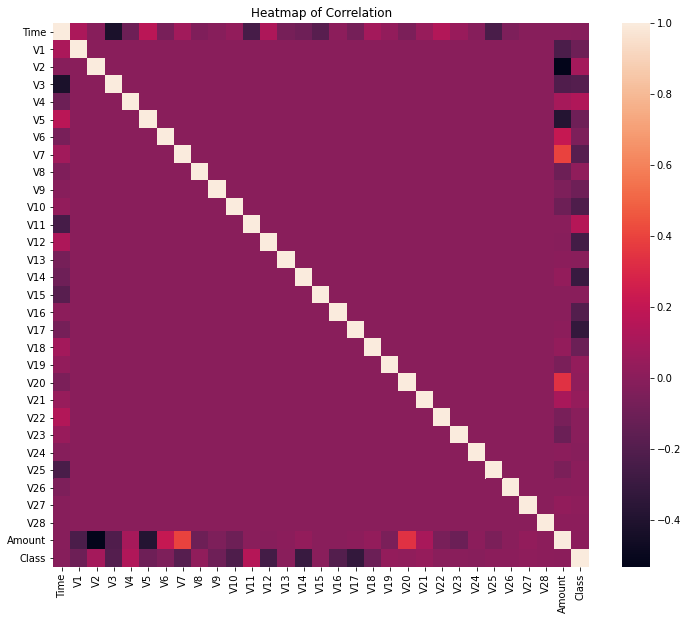

In [15]:
#heatmap
corr = data.corr()
plt.figure(figsize=(12,10))
heat = sns.heatmap(data=corr)
plt.title('Heatmap of Correlation')

### <font color=red>OBSERVATIONS</font>

&#9658; **In the HeatMap we can clearly see that most of the features do not correlate to other features but there are some features that either has a positive or a negative correlation with each other.<br> 
&#9658; For example “V2” and “V5” are highly negatively correlated with the feature called “Amount”. We also see some correlation with “V20” and “Amount”. This gives us a deeper understanding of the Data available to us.**

<h2><font color=red>Analysis of Time Column</font></h2>

<h3><font color=blue>Class vs Time</font></h3>

**Let's plot the distribution of the classes with respect to time for both fraudulent and normal transactions.**

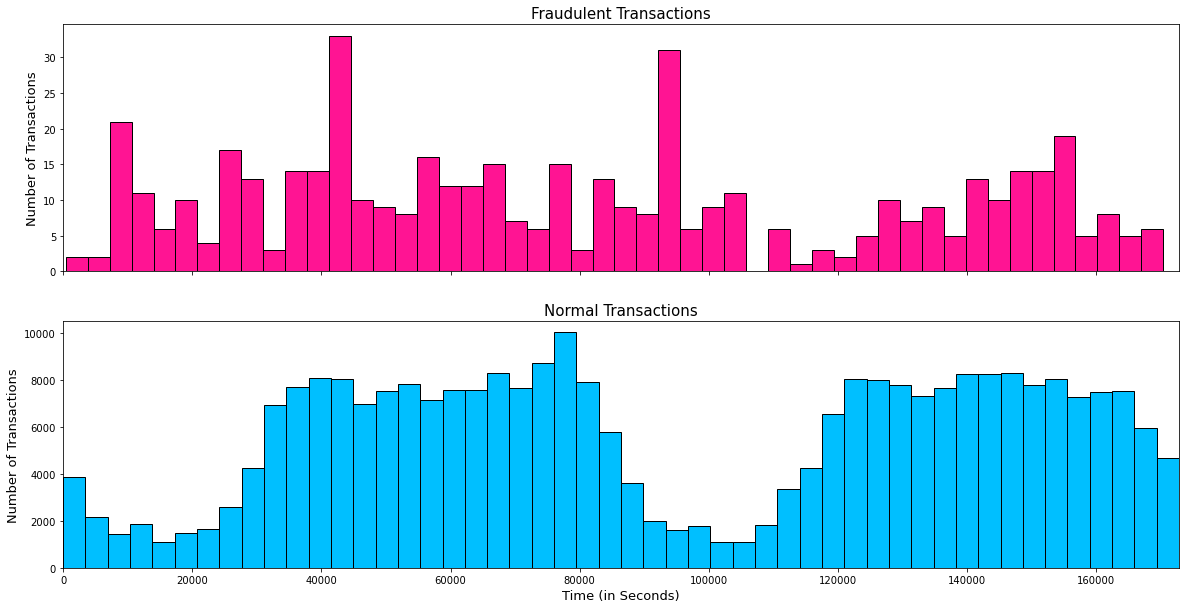

In [16]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20,10))

fraud_transactions = data.Time[data.Class == 1]
normal_transactions = data.Time[data.Class == 0]

ax1.hist(fraud_transactions, bins = 50, color='deeppink', edgecolor="black")
ax1.set_xlim([min(fraud_transactions), max(fraud_transactions)])
ax1.set_title('Fraudulent Transactions', fontsize=15)
ax1.set_ylabel("Number of Transactions",  fontsize=13)

ax2.hist(normal_transactions, bins = 50, color='deepskyblue', edgecolor="black")
ax2.set_xlim([min(normal_transactions), max(normal_transactions)])
ax2.set_title('Normal Transactions',  fontsize=15)

ax2.set_xlabel('Time (in Seconds)',  fontsize=13)
ax2.set_ylabel('Number of Transactions',  fontsize=13)

plt.show()

<h3 align="center"><font color=red>OBSERVATIONS</font></h3>

#### <font color=blue>FRAUDULENT</font>

>&#9658; **There are two peaks between 40000 seconds and 100000 seconds which were the maximum number of fraudulent transaction at any time.**


#### <font color=blue>NORMAL</font>

>&#9658; **Normal transactions have not much to uncover except the fact that there were less transactions somewhere around 20000 seconds and 100000 seconds which is not very useful.**

&#9658; **Let's do some feature engineering on time and transform it to minutes and hours to uncover some of the hidden patterns.**

In [17]:
# converting seconds to time delta to extract hours and mins

timedelta = pd.to_timedelta(data['Time'], unit='s')

data['mins'] = (timedelta.dt.components.minutes).astype(int)
data['hours'] = (timedelta.dt.components.hours).astype(int)

>&#9658; **Let's look at the distribution of number of transactions for each hour for total, fraudulent and normal transactions.**

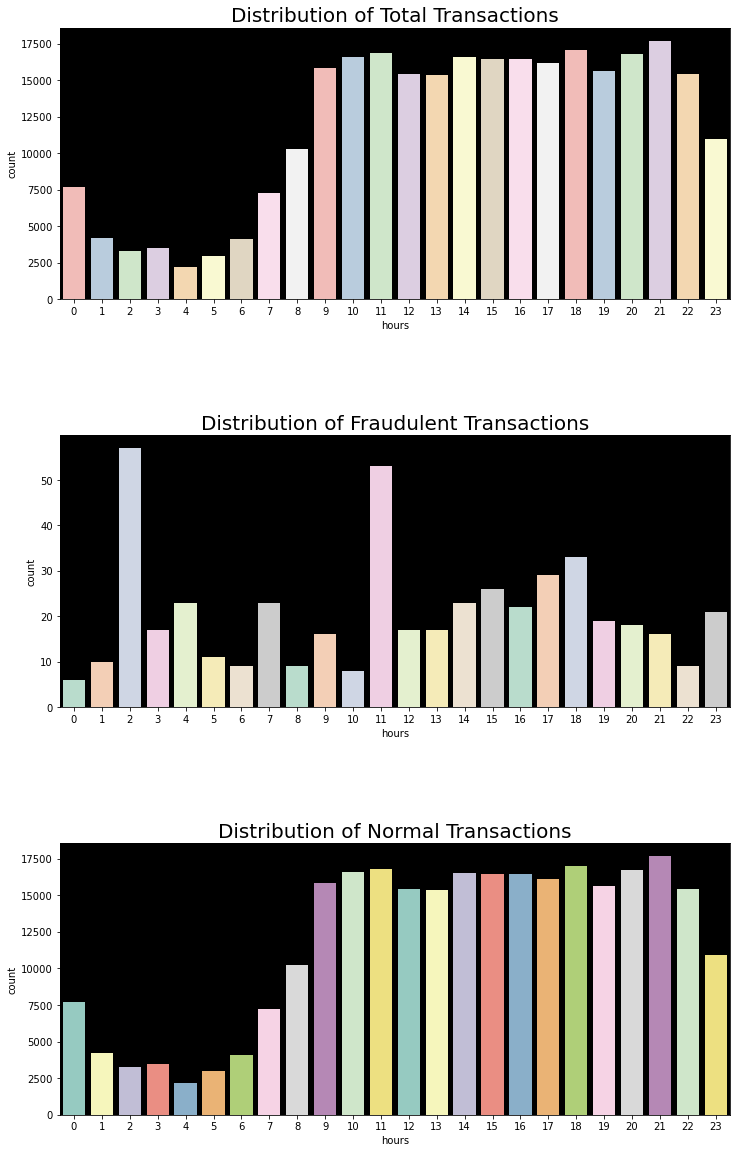

In [18]:
# Countplots for hours vs count of transactions

fig, axs = plt.subplots(3, figsize=(12,20))

fig.subplots_adjust(hspace=.5)

sns.countplot(data['hours'], ax = axs[0], palette="Pastel1")
axs[0].set_title("Distribution of Total Transactions",fontsize=20)
axs[0].set_facecolor("black")

sns.countplot(data[(data['Class'] == 1)]['hours'], ax=axs[1], palette='Pastel2')
axs[1].set_title("Distribution of Fraudulent Transactions", fontsize=20)
axs[1].set_facecolor('black')

sns.countplot(data[(data['Class'] == 0)]['hours'], ax=axs[2], palette='Set3')
axs[2].set_title("Distribution of Normal Transactions", fontsize=20)
axs[2].set_facecolor("black")

plt.show()

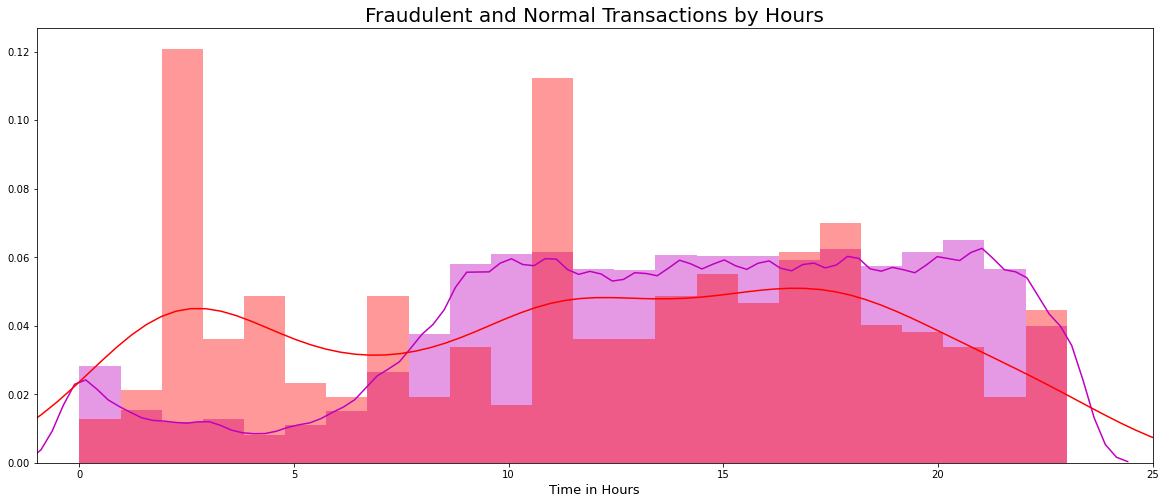

In [19]:
# Exploring the distribuition by Class types throught hours and minutes

plt.figure(figsize=(20,8))

sns.distplot(data[data['Class'] == 0]['hours'], bins=24, color='m')
sns.distplot(data[data['Class'] == 1]["hours"], bins=24, color='r')

plt.title('Fraudulent and Normal Transactions by Hours', fontsize=20)

plt.xlabel("Time in Hours", fontsize=13)
plt.xlim([-1,25])
plt.show()

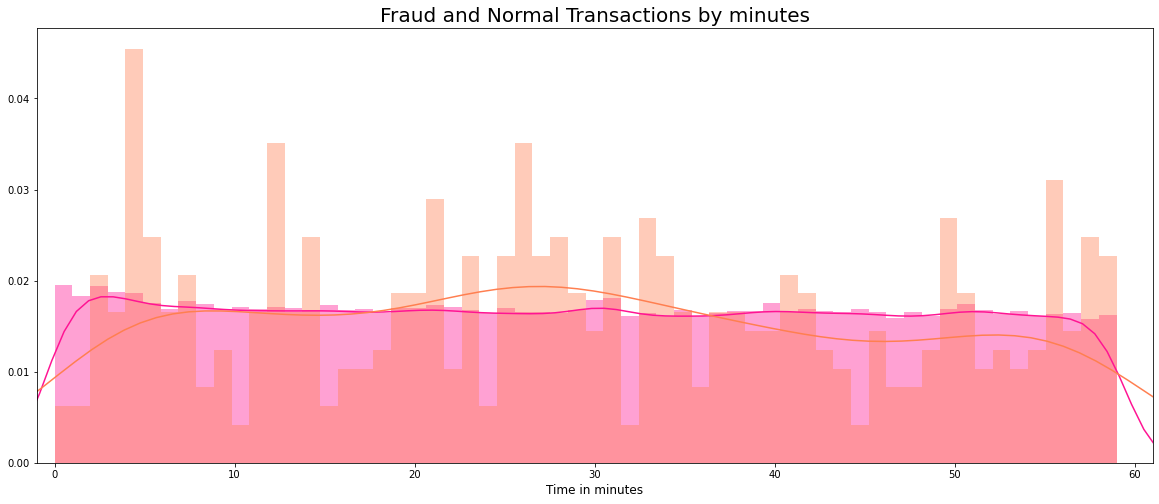

In [20]:
#Exploring the distribuition by Class types throught hours and minutes

plt.figure(figsize=(20,8))

sns.distplot(data[data['Class'] == 0]["mins"], bins =60, color='deeppink')
sns.distplot(data[data['Class'] == 1]["mins"], bins =60, color='coral')

plt.title('Fraud and Normal Transactions by minutes', fontsize=20)
plt.xlim([-1,61])
plt.xlabel("Time in minutes", fontsize=12)
plt.show()

<h3><font color=red>OBSERVATIONS</font></h3>

&#9658; **The plots of both hours and minutes doesn't have any interesting trend.**

<h3><font color=blue>Class and Amount vs Time</font></h3>

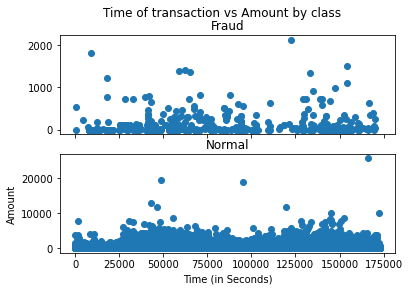

In [21]:
# We Will check Do fraudulent transactions occur more often during certain time frame ? Let us find out with a visual representation.

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

### <font color=red>OBSERVATIONS</font>

#### <font color=blue>FRAUDULENT</font>

>&#9658; **There are much more outliers as compared to normal transactions.**<br><br>
>&#9658; **The plot seems to not have any inherent pattern.**<br><br>

#### <font color=blue>NORMAL</font>

> &#9658; **There are a less number of outliers as compared to fraudulent transactions.**<br><br>
> &#9658; **There are a lot of transactions with amount less than 5000.**<br>

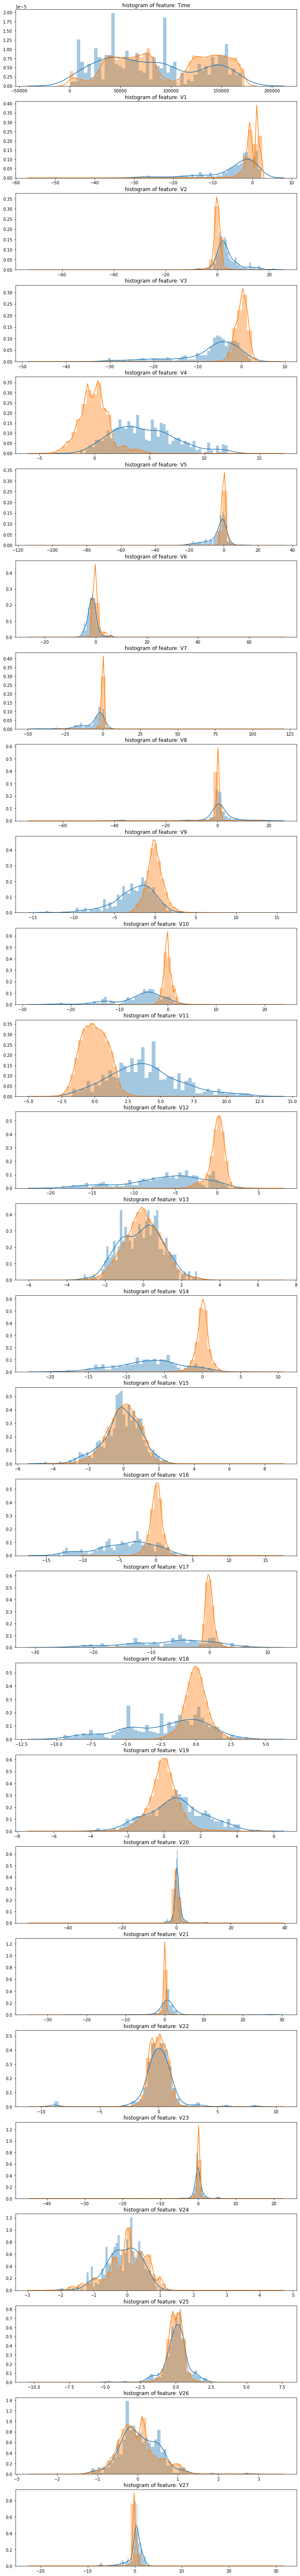

In [22]:
# distribution of anomalous features
features = data.iloc[:,0:28].columns
plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(28, 1)
for i, c in enumerate(data[features]):
 ax = plt.subplot(gs[i])
 sns.distplot(data[c][data.Class == 1], bins=50)
 sns.distplot(data[c][data.Class == 0], bins=50)
 ax.set_xlabel('')
 ax.set_title('histogram of feature: ' + str(c))
plt.show()

<h3><font color=red>OBSERVATIONS</font></h3>

&#9658; **For some of the features we can observe a good selectivity in terms of distribution for the two values of Class: V4, V11 have clearly separated distributions for Class values 0 and 1, V12, V14, V18 are partially separated, V1, V2, V3, V10 have a quite distinct profile, whilst V20-V28 have similar profiles for the two values of Class and thus not very useful in differentiation of both the classes.**

&#9658; **In general, with just few exceptions (Time and Amount), the features distribution for legitimate transactions (values of Class = 0) is centered around 0, sometime with a long queue at one of the extremities. In the same time, the fraudulent transactions (values of Class = 1) have a skewed (asymmetric) distribution.**

In [23]:
# copy of data for future use

temp = data.copy()

<h1><font color=red>Data Cleaning and Preprocessing</font></h1>

<h2><font color=blue>Outlier Removal</font></h2>

&#9658; **As we already saw that amount column has a extreme outliers so it necessary to remove them as they can effect the model's performance. We will used Interquartile range to detect outliers which removes anything below the lower limit (25 percentile) and anything above upper limit (75 Percentile).**

&#9658; **Note that, the data we have for fraudulent cases is very low so we wanna keep our cutoff a bit high so as avoid removing much of the fraud cases. Here, as the data is skewed (kind of exponential) so having high cutoff will help us. Let's take the cutoff value as 5.0 instead of 1.5 which is usually used.**

In [24]:
# Finding the 3rd and 1st Quantile for Amount Column

Q3 = np.percentile(data['Amount'], 75)
Q1 = np.percentile(data['Amount'], 25)

# setting the cutoff
cutoff = 5.0

# computing the interquartile range
IQR = (Q3 - Q1)

# computing lower bound and upper bound
lower_bound = Q1 - (IQR * cutoff)
upper_bound = Q3 + (IQR * cutoff)

# creating a filter to remove values less than lower bound and greater than
# upper bound
filter_data = (data['Amount'] < lower_bound) | (data['Amount'] > upper_bound)

# filtering data
outliers = data[filter_data]['Amount']
fraud_outliers = data[(data['Class'] == 1) & filter_data]['Amount']
normal_outliers = data[(data['Class'] == 0) & filter_data]['Amount']

print(f"Total Number of Outliers : {outliers.count()}")
print(f"Number of Outliers in Fraudulent Class : {fraud_outliers.count()}")
print(f"No of Outliers in Normal Class : {normal_outliers.count()}")
print(f"Percentage of Fraud amount outliers : {round((fraud_outliers.count()/outliers.count())*100,2)}%")

Total Number of Outliers : 11366
Number of Outliers in Fraudulent Class : 41
No of Outliers in Normal Class : 11325
Percentage of Fraud amount outliers : 0.36%


In [25]:
data = data.drop(outliers.index)
data.reset_index(inplace=True, drop=True)

In [26]:
data.head().style.set_properties(**{"background-color":"black",
                           "color" : "skyblue"})

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,mins,hours
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.620000,0,0,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.690000,0,0,0
2,1.000000,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.660000,0,0,0
3,1.000000,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.500000,0,0,0
4,2.000000,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.990000,0,0,0


In [27]:
data.shape

(273441, 33)

>&#9658; **We have successfully removed the outliers now and we let's scale the Amount feature so that our model isn't baised towards amount feature.**

In [28]:
#dropping mins and hours columns
data.drop(['mins','hours'],axis = 1 , inplace = True)

In [29]:
data.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
191160,132876.0,1.599841,-2.400180,-2.007466,-1.307050,-1.059050,-0.672148,-0.146397,-0.410871,-1.570552,...,-0.082894,-0.642309,-0.064843,0.587946,-0.199790,-0.300694,-0.093873,0.011529,398.72,0
18888,30313.0,-0.497846,1.073668,0.865929,-0.145298,2.246981,0.499517,1.840470,-1.295094,0.300158,...,-0.410970,-0.208102,-0.711052,-1.453786,0.388015,0.385841,-1.444708,-1.271755,0.76,0
67344,53873.0,-0.980776,-0.474532,3.053943,-1.089247,-1.272891,0.135933,-0.809686,0.416687,0.287993,...,-0.531577,-0.650889,-0.166630,0.431563,0.208222,1.019558,0.275293,0.128208,10.00,0
161164,118877.0,1.790748,-0.211137,-3.039448,0.971395,1.522749,-0.178648,1.156942,-0.363115,-0.504771,...,0.393767,0.875447,-0.477466,-0.299561,0.926444,-0.198433,-0.094343,-0.062156,180.00,0
44950,42957.0,0.959462,-0.837923,-0.526282,-0.835878,-0.446670,-0.426657,0.090304,0.086908,1.351889,...,0.097214,0.063442,-0.315845,-0.325875,0.749893,-0.524248,0.001538,0.014697,152.46,0


<h2><font color=blue>Feature Scaling</font></h2>

&#9658; **As the amount column is highly skewed so it will be better to apply log transoformation as it can result in nearly normal distribution which is suited for most of the algorithms.**

In [30]:
# applying log transformation of Amount column

data['Amount'] = np.log(data['Amount']+ 0.001)

Text(0.5, 1.0, 'Box Plot for Transformed Amount Feature')

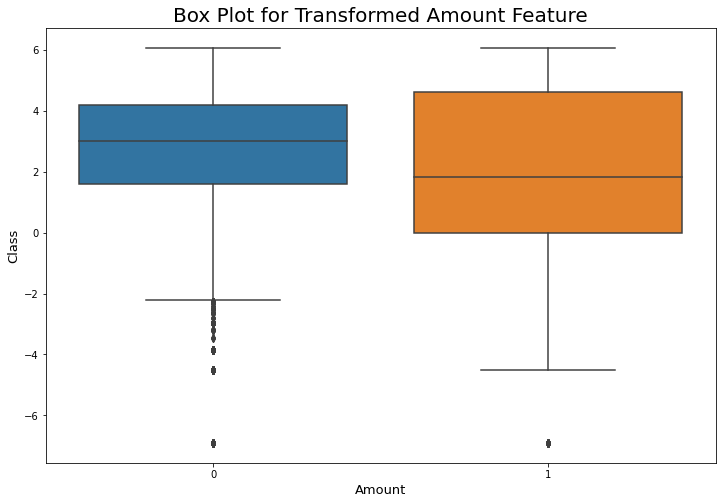

In [31]:
# Box Plot for transformed Amount feature with class
plt.figure(figsize = (12,8))
sns.boxplot(x= "Class", y = "Amount", data = data)
plt.xlabel("Amount",fontsize = 13)
plt.ylabel("Class",fontsize = 13)
plt.title("Box Plot for Transformed Amount Feature", fontsize = 20)

>&#9658; **Now let's scale the time column but we will use normal scaling this time.**

In [32]:
# scaling the time column

robust_scaler = RobustScaler()
data['Time'] = robust_scaler.fit_transform(data['Time'].values.reshape(-1,1))

In [33]:
#Create independent and Dependent Features
columns = data.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["Class"]]
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(42)
X = data[columns]
Y = data[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(273441, 30)
(273441,)


<h2><font color=blue> Handling Class Imbalance </font></h2>

&#9658; **Imbalanced data is a problem in supervised learning problems which can result is high bias towards majority class. As we have already seen that this data is severly imbalanced so to balance it we can use various techniques such as:** 

- **Oversampling**
- **Undersampling** 
- **SMOTE**

&#9658; **Out of all these three SMOTE is the most effective so we will go with it, In this technique, instead of simply duplicating data from the minority class, we synthesize new data from the minority class. This is a type of data augmentation for tabular data can be very effective. This approach to synthesizing new data is called the Synthetic Minority Oversampling TEchnique, or SMOTE for short.**

In [34]:
print(f'Original dataset shape : {Counter(Y)}')

smote = SMOTE(random_state = 42)
X_res,y_res = smote.fit_resample(X,Y)

print(f'Resampled dataset shape {Counter(y_res)}')

Original dataset shape : Counter({0: 272990, 1: 451})
Resampled dataset shape Counter({0: 272990, 1: 272990})


>&#9658; **We can clearly see that now the data is completely balanced so let's use some visualisation technique to visualize this data.**

>&#9658; **Note that, as our data has a lot of columns and humans can only understand 3D so we will use Dimensionality reduction technique to reduce our data to 3D and then plot it. So, let's get started!**

<h2><font color=blue> Dimensionality Reduction and Clustering </font></h2>

&#9658; **For the dimesionality reduction I will use t-SNE. It is state-of-the-art in visualising high dimensional data and can help us understand how our model will perform or how seperable the data is using clusters. It outperforms PCA**

In [35]:
# creating a random sample of 5000 points

X_vis = X_res.sample(6000,random_state = 42)
y_vis = y_res.sample(6000,random_state = 42)

print(X_vis.shape)
print(y_vis.shape)

(6000, 30)
(6000,)


In [36]:
#training the t-SNE model to reduce dimensionality

tsne3d = TSNE(n_components = 3, random_state = 42,verbose = 2,perplexity = 50).fit_transform(X_vis)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 6000 samples in 0.056s...
[t-SNE] Computed neighbors for 6000 samples in 1.864s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 2.005844
[t-SNE] Computed conditional probabilities in 0.544s
[t-SNE] Iteration 50: error = 80.2780685, gradient norm = 0.0279536 (50 iterations in 13.895s)
[t-SNE] Iteration 100: error = 72.0957413, gradient norm = 0.0023221 (50 iterations in 8.140s)
[t-SNE] Iteration 150: error = 71.0811234, gradient norm = 0.0009717 (50 iterations in 7.215s)
[t-SNE] Iteration 200: error = 70.7122803, gradient norm = 0.0006496 (50 iterations in 6.815s)


In [37]:
# plotting a 3D scatter plot 

trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        color = y_vis,
        colorscale = ['deeppink', 'deepskyblue'],
        colorbar = dict(title = 'Fraud'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.5
    )
)

data=[trace1]

layout = dict(title = 'TSNE (T-Distributed Stochastic Neighbourhood Embedding)',
              showlegend=False, height=800, width=800,)

fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

> &#9658; **As expected, t-SNE is performing well, seperating both the classes. The clusters are not perfectly seperated but it is able to seperate almost 80% of the sample data which is cool.**

<h2><font color=blue> Splitting the data </font></h2>

&#9658; **As our data is imbalanced so we will not use train_test_split and instead we will use stratified split which will take the representative of respective populations i.e Fraud Transactions and Normal Transactions.**

In [38]:
#creating instance of stratifiedkfold split for 5 splits

strat = StratifiedKFold(n_splits = 5, random_state = None , shuffle = False)

#splitting the data

for train_index,test_index in strat.split(X,Y):
    print("Train:" , train_index , "Test:",test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index],X.iloc[test_index]
    original_ytrain, original_ytest = Y.iloc[train_index],Y.iloc[test_index]
    
    

Train: [ 29350  29392  29422 ... 273438 273439 273440] Test: [    0     1     2 ... 54742 54743 54744]
Train: [     0      1      2 ... 273438 273439 273440] Test: [ 29350  29392  29422 ... 109415 109416 109417]
Train: [     0      1      2 ... 273438 273439 273440] Test: [ 76259  76295  76304 ... 164124 164125 164126]
Train: [     0      1      2 ... 273438 273439 273440] Test: [144542 144548 144549 ... 218769 218770 218771]
Train: [     0      1      2 ... 218769 218770 218771] Test: [203831 204371 204395 ... 273438 273439 273440]


In [39]:
# Turning the splits into an array 

#original_Xtrain = original_Xtrain.values
#original_Xtest = original_Xtest.values
#original_ytrain = original_ytrain.values
#original_ytest = original_ytest.values

In [40]:
print(original_ytest.shape)

(54688,)


<h1><font color=red> Modelling </font></h1>

&#9658; **In this section, we will finally apply models and classify whether a certain transaction done a particular time is fraud or geniune. Thus, this is a binary classification problem.**

&#9658; **One thing we should keep in mind that we might get very high accuracy but we should focus on optimising out f1_score and recall as we want to perform better on fraud cases as they are the most important.**

##### <h2><font color=red> Confusion Matrix </font></h2>

**Positive/Negative:** Type of Class (label)   ["Normal","Fraud"] <br><br>
**True/False:** Correctly or Incorrectly classified by the model.<br><br>
**True Positives (Bottom-Right Square):** This is the number of **correctly** classifications of the "Yes" (Fraud Detected) class.<br><br>

**False Negatives (Bottom-Left Square):** This is the number of **incorrectly** classifications of the "Yes" (Fraud Detected)  class. <br><br>

**False Positives (Top-Right Square):**This is the number of **incorrectly** classifications of the "No"(No Fraud Detected) class.<br><br>

**True Negatives (Top-Left Square):** This is the number of **correctly** classifications of the "No" (No Fraud Detected) class. <br><br>

In [41]:
# Creating a function to plot correlation matrix and roc_auc_curve

def show_metrics(model, y_test, y_pred):
    fig = plt.figure(figsize=(20, 8))

    # Confusion matrix
    ax = fig.add_subplot(121)
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, annot_kws={"size": 16}, fmt='g', 
                cmap='Set3', linewidths=1, linecolor='white')

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels', fontsize=15);
    ax.set_ylabel('Actual labels', fontsize=15); 
    ax.set_title("Confusion Matix", fontsize=20) 
    ax.xaxis.set_ticklabels(['Normal', 'Fraud'], fontsize=12); 
    ax.yaxis.set_ticklabels(['Normal', 'Fraud'], fontsize=12);

    # ROC Curve
    fig.add_subplot(122)
    
    
    auc_roc = roc_auc_score(y_test, model.predict(original_Xtest))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(original_Xtest)[:,1])

    plt.plot(fpr, tpr, color='darkturquoise', lw=2, marker='o', label='Trained Model (area = {0:0.3f})'.format(auc_roc))
    plt.plot([0, 1], [0, 1], color='deeppink', lw=2, linestyle='--', label= 'No Skill (area = 0.500)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=13)
    plt.ylabel('True Positive Rate', fontsize=13)
    plt.title('Receiver operating characteristic', fontsize=20)
    plt.legend(loc="lower right")
    plt.show()

<h2><font color=blue> Logistic Regression </font></h2>

In [42]:
log_reg = LogisticRegression()
model = log_reg.fit(original_Xtrain,original_ytrain)
predictions = log_reg.predict(original_Xtest)

In [43]:
recall = recall_score(original_ytest,predictions)  # recall refers to the percentage of total relevant results correctly classified by your algorithm
accuracy = accuracy_score(original_ytest,predictions)
f1 = f1_score(original_ytest,predictions)
precision = precision_score(original_ytest,predictions) #Precision means the percentage of your results which are relevant
n_errors = (predictions!=original_ytest).sum()
print("{}:{}".format(model,n_errors))
print("Accuracy: {0:0.2f}%".format(np.mean(accuracy)*100))
print("Precision: {0:0.2f}".format(np.mean(precision)))
print("Recall: {0:0.2f}".format(np.mean(recall)))
print("f1 Score: {0:0.2f}".format(np.mean(f1)))

LogisticRegression():55
Accuracy: 99.90%
Precision: 0.91
Recall: 0.43
f1 Score: 0.59


In [44]:
print(classification_report(original_ytest,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     54598
           1       0.91      0.43      0.59        90

    accuracy                           1.00     54688
   macro avg       0.95      0.72      0.79     54688
weighted avg       1.00      1.00      1.00     54688



In [45]:
print(confusion_matrix(original_ytest,predictions))

[[54594     4]
 [   51    39]]


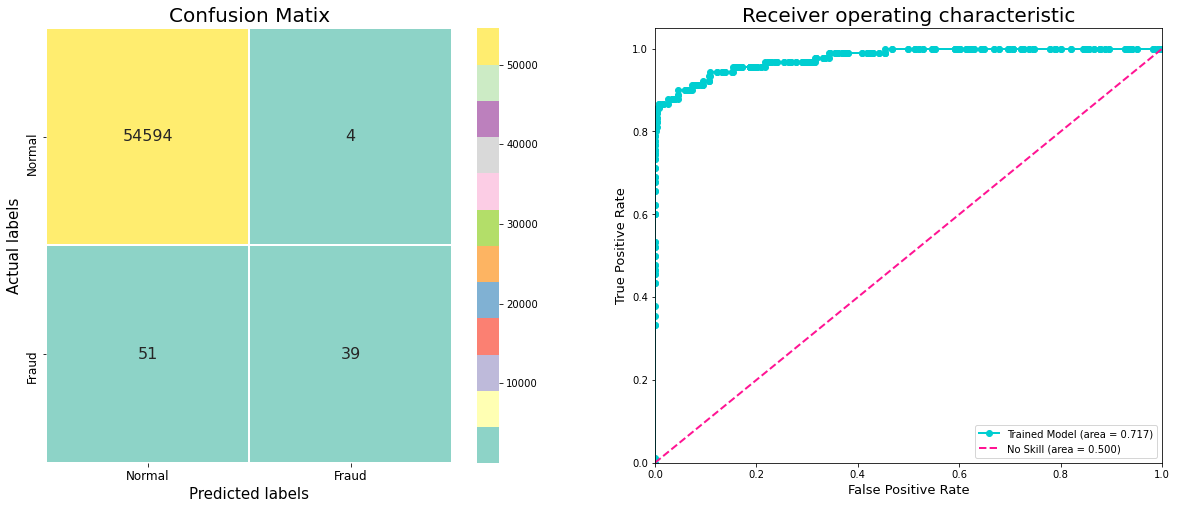

In [46]:
show_metrics(model,original_ytest,predictions)

<h3><font color=red>OBSERVATIONS</font></h3>

&#9658; **Logistic Regression did not work well on the imbalanced data as the recall value came out to be just 43% . Here we will not focus on Accuracy score as this is an highly imbalanced dataset.** <br><br>
&#9658; **We get a total of 55 errors or misclassification**<br><br>
&#9658; **Here we can see that Recall value is pretty low which implies that False Negative is high, 51 Fraud Transaction were classified as Normal Transactions**<br><br>
&#9658; **By HIGHER Recall value we identify that the actual fraud transactions which were Incorrectly Predicted as Normal Transaction(i.e. False Negative) is LOW** <br><br>

<h2><font color=blue> Random Forest Classifier </font></h2>

In [47]:
rnd_clf = RandomForestClassifier(random_state=state)
model = rnd_clf.fit(original_Xtrain,original_ytrain)
predictions = rnd_clf.predict(original_Xtest)

In [48]:
recall = recall_score(original_ytest,predictions)  # recall refers to the percentage of total relevant results correctly classified by your algorithm
accuracy = accuracy_score(original_ytest,predictions)
f1 = f1_score(original_ytest,predictions)
precision = precision_score(original_ytest,predictions) #Precision means the percentage of your results which are relevant
n_errors = (predictions!=original_ytest).sum()
print("{}:{}".format(model,n_errors))

print("Accuracy: {0:0.2f}%".format(np.mean(accuracy)*100))
print("Precision: {0:0.2f}".format(np.mean(precision)))
print("Recall: {0:0.2f}".format(np.mean(recall)))
print("f1 Score: {0:0.2f}".format(np.mean(f1)))

RandomForestClassifier(random_state=RandomState(MT19937) at 0x211831176A8):30
Accuracy: 99.95%
Precision: 1.00
Recall: 0.67
f1 Score: 0.80


In [49]:
print(classification_report(original_ytest,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     54598
           1       1.00      0.67      0.80        90

    accuracy                           1.00     54688
   macro avg       1.00      0.83      0.90     54688
weighted avg       1.00      1.00      1.00     54688



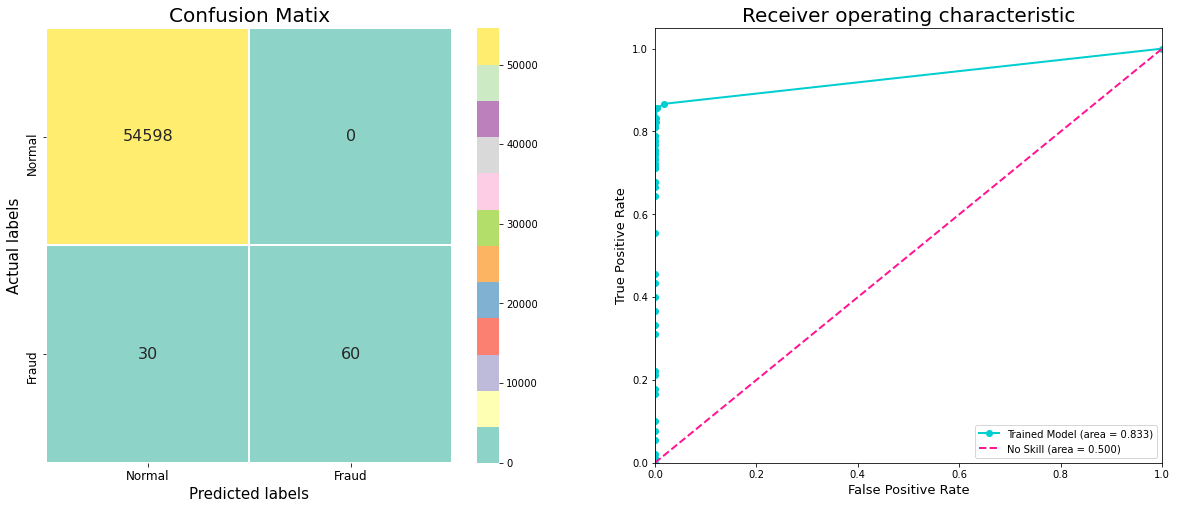

In [50]:
show_metrics(model,original_ytest,predictions)

<h3><font color=red>OBSERVATIONS</font></h3>

&#9658; **Random Forest did work pretty well on the imbalanced data as the recall value came out to be 67% . Here we will not focus on Accuracy score as this is an highly imbalanced dataset.** <br><br>
&#9658; **We get a total of 30 errors or misclassification which are all the False Negative with 0 False Positive**<br><br>
&#9658; **Here we can see that Recall value is better than the Logistic Regression which implies that False Negative is low, 30 Fraud Transaction were classified as Normal Transactions**<br><br>
&#9658; **By HIGHER Recall value we identify that the actual fraud transactions which were Incorrectly Predicted as Normal Transaction(i.e. False Negative) is LOW** <br><br>

**From here , we will start using different methods to create new data and apply models**

<h2><font color=blue> Oversampling</font></h2>

&#9658; **Oversampling consists of copying instances of the minority class in order to equal or increase its amount when compared to the majority class. There are some methods of using this, we will focus on three:**<br>

- **Random Oversampling**
- **SMOTE**
- **Adaptive Synthetic Sampling**

&#9658; **Each will be explained when used**<br>


## <font color=blue> Random Oversampling</font>

&#9658; **Random Oversampling randomly replicates the minority class instances. It has some drawbacks**

In [51]:
ros = RandomOverSampler(random_state=state)

X_res, y_res = ros.fit_resample(original_Xtrain, original_ytrain)

X_res = pd.DataFrame(X_res, columns = original_Xtrain.columns)
y_res = pd.Series(y_res)


In [52]:
percentage_fraud = len(y_res[y_res == 1]) / len(y_res)
percentage_fraud

0.5

In [53]:
print(X_res.shape,y_res.shape)

(436784, 30) (436784,)


**Applying some classifiers**

In [54]:
log_reg = LogisticRegression()
model = log_reg.fit(X_res, y_res)
predictions = log_reg.predict(original_Xtest)

In [55]:
recall = recall_score(original_ytest,predictions)  # recall refers to the percentage of total relevant results correctly classified by your algorithm
accuracy = accuracy_score(original_ytest,predictions)
f1 = f1_score(original_ytest,predictions)
precision = precision_score(original_ytest,predictions) #Precision means the percentage of your results which are relevant
n_errors = (predictions!=original_ytest).sum()
print("{}:{}".format(model,n_errors))

print("Accuracy: {0:0.2f}%".format(np.mean(accuracy)*100))
print("Precision: {0:0.2f}".format(np.mean(precision)))
print("Recall: {0:0.2f}".format(np.mean(recall)))
print("f1 Score: {0:0.2f}".format(np.mean(f1)))

LogisticRegression():441
Accuracy: 99.19%
Precision: 0.16
Recall: 0.88
f1 Score: 0.26


In [56]:
print(classification_report(original_ytest,predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     54598
           1       0.16      0.88      0.26        90

    accuracy                           0.99     54688
   macro avg       0.58      0.93      0.63     54688
weighted avg       1.00      0.99      0.99     54688



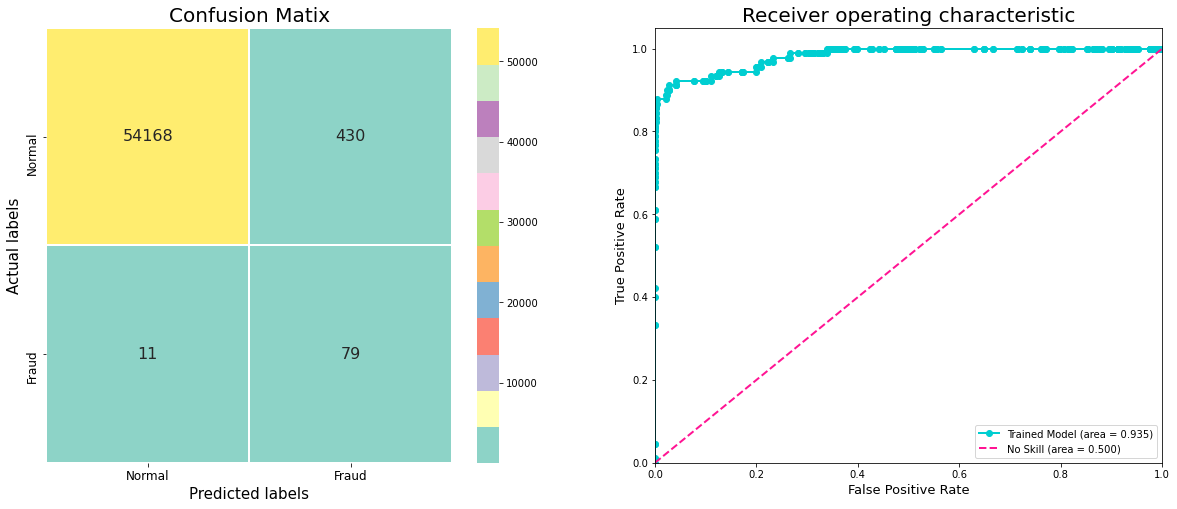

In [57]:
show_metrics(model,original_ytest,predictions)

**Repeating our strategy again with different ratios just to check if we don't have some overfitting**

In [58]:
ros = RandomOverSampler(sampling_strategy = 0.4 ,random_state=state)

X_res, y_res = ros.fit_resample(original_Xtrain, original_ytrain)

X_res = pd.DataFrame(X_res, columns = original_Xtrain.columns)
y_res = pd.Series(y_res)


In [59]:
percentage_fraud = len(y_res[y_res == 1]) / len(y_res)
percentage_fraud

0.28571241676151604

**Applying some classifiers**

In [60]:
log_reg = LogisticRegression()
model = log_reg.fit(X_res, y_res)
predictions = log_reg.predict(original_Xtest)

In [61]:
recall = recall_score(original_ytest,predictions)  # recall refers to the percentage of total relevant results correctly classified by your algorithm
accuracy = accuracy_score(original_ytest,predictions)
f1 = f1_score(original_ytest,predictions)
precision = precision_score(original_ytest,predictions) #Precision means the percentage of your results which are relevant
n_errors = (predictions!=original_ytest).sum()
print("{}:{}".format(model,n_errors))

print("Accuracy: {0:0.2f}%".format(np.mean(accuracy)*100))
print("Precision: {0:0.2f}".format(np.mean(precision)))
print("Recall: {0:0.2f}".format(np.mean(recall)))
print("f1 Score: {0:0.2f}".format(np.mean(f1)))

LogisticRegression():195
Accuracy: 99.64%
Precision: 0.30
Recall: 0.86
f1 Score: 0.44


In [62]:
print(classification_report(original_ytest,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     54598
           1       0.30      0.86      0.44        90

    accuracy                           1.00     54688
   macro avg       0.65      0.93      0.72     54688
weighted avg       1.00      1.00      1.00     54688



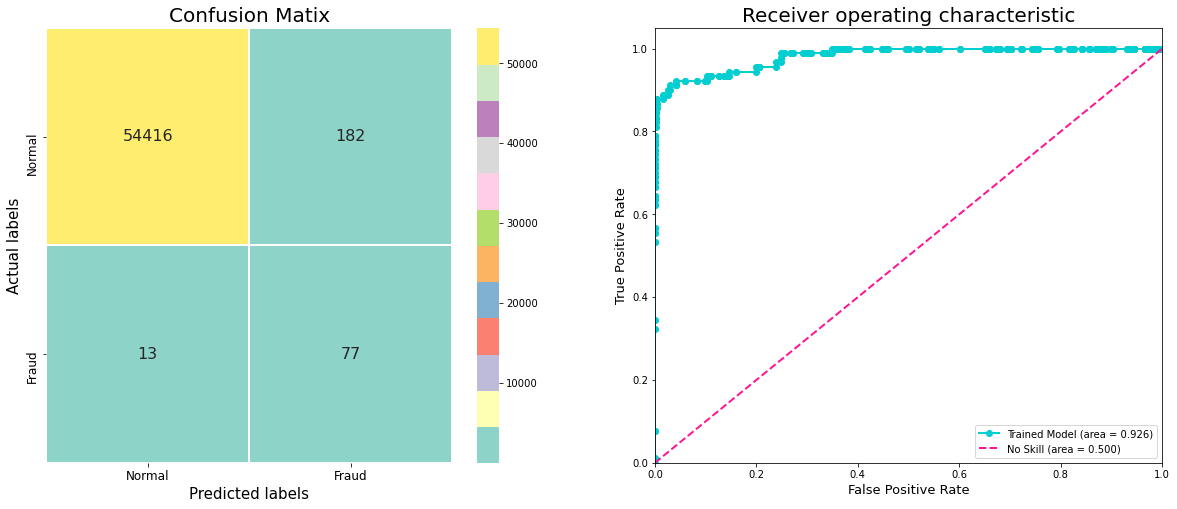

In [63]:
show_metrics(model,original_ytest,predictions)

<h3><font color=red>OBSERVATIONS</font></h3>

&#9658; **Within Random Oversampling we can observe that we get a good recall score of  88% and on changing the ratio of sampling strategy from default ratio auto(resample all classes but the majority class) to 0.4 (desired ratio of the number of samples in the minority class over the number of samples in the majority class after resampling) we get a recall score of 86%**<br><br>
&#9658; **Random Oversampling did work pretty well on the balanced data via oversampling technique as the recall value came out to be 88% .** <br><br>
&#9658; **We get a total of 441(auto) and 195(0.4) errors or misclassification**<br><br>
&#9658; **Here we can see that Recall value is pretty high which implies that False Negative is low, just 11 and 13 Fraud Transaction were classified as Normal Transactions**<br><br>
&#9658; **But here we see a good decrease in the amount of False positive {430 -> 182} by changing the sampling strategy from auto to 0.4 which is good as it increases the True Negative classification without any significant increase in False Negative**<br><br>
&#9658; **By HIGHER Recall value we identify that the actual fraud transactions which were Incorrectly Predicted as Normal Transaction(i.e. False Negative) is LOW** <br><br>

## <font color=blue> SMOTE</font>

&#9658; **To avoid the over-fitting problem, Chawla et al. (2002) propose the Synthetic Minority Over-sampling Technique (SMOTE).This method is considered a state-of-art technique and works well in various applications.** <br>
&#9658; **This method generates synthetic data based on the feature space similarities between existing minority instances.**<br>
&#9658; **In order to create a synthetic instance, it finds the K-nearest neighbors of each minority instance, randomly selects one of them, and then calculate linear interpolations to produce a new minority instance in the neighborhood.**

In [64]:
sm = SMOTE(random_state = state, k_neighbors = 5)

X_smote, y_smote = sm.fit_resample(original_Xtrain, original_ytrain)

X_smote = pd.DataFrame(X_smote, columns = original_Xtrain.columns)
y_smote = pd.Series(y_smote)

In [65]:
print(X_smote.shape,y_smote.shape)

(436784, 30) (436784,)


In [66]:
log_reg = LogisticRegression()
model = log_reg.fit(X_smote, y_smote)
predictions = log_reg.predict(original_Xtest)

In [67]:
recall = recall_score(original_ytest,predictions)  # recall refers to the percentage of total relevant results correctly classified by your algorithm
accuracy = accuracy_score(original_ytest,predictions)
f1 = f1_score(original_ytest,predictions)
precision = precision_score(original_ytest,predictions) #Precision means the percentage of your results which are relevant
n_errors = (predictions!=original_ytest).sum()
print("{}:{}".format(model,n_errors))

print("Accuracy: {0:0.2f}%".format(np.mean(accuracy)*100))
print("Precision: {0:0.2f}".format(np.mean(precision)))
print("Recall: {0:0.2f}".format(np.mean(recall)))
print("f1 Score: {0:0.2f}".format(np.mean(f1)))

LogisticRegression():448
Accuracy: 99.18%
Precision: 0.15
Recall: 0.87
f1 Score: 0.26


In [68]:
print(classification_report(original_ytest,predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     54598
           1       0.15      0.87      0.26        90

    accuracy                           0.99     54688
   macro avg       0.58      0.93      0.63     54688
weighted avg       1.00      0.99      0.99     54688



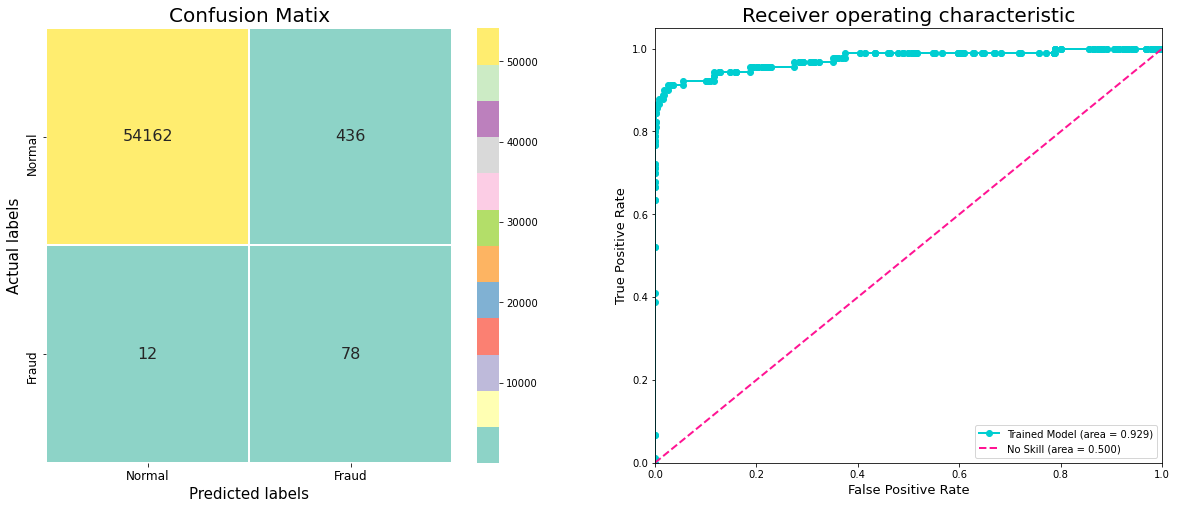

In [69]:
show_metrics(model,original_ytest,predictions)

<h3><font color=red>OBSERVATIONS</font></h3>

&#9658; **Within SMOTE we can observe that we get a good recall score of  87% along with an accuracy of 99.18% but we care about recall score more**<br><br>
&#9658; **SMOTE did work pretty well on the balanced data via oversampling technique as the recall value came out to be 87% .** <br><br>
&#9658; **We get a total of 448 errors or misclassification**<br><br>
&#9658; **Here we can see that Recall value is pretty high which implies that False Negative is low, 12 Fraud Transaction were classified as Normal Transactions**<br><br>
&#9658; **We can observe a high amount of False positive(436)**<br><br>
&#9658; **By HIGHER Recall value we identify that the actual fraud transactions which were Incorrectly Predicted as Normal Transaction(i.e. False Negative) is LOW** <br><br>

## <font color=blue> ADASYN</font>

&#9658; **ADASYN is, like SMOTE, a synethtic data generator. It also generates data through a K-Neighbours perspective, but it also takes into account the density of a certain neighbour of K-Neighbours.** <br>

#### Step 0

First, set some variables.

Let $m_l$ and $m_g$ be, respectively, the amount of samples for the minority and majority classes. Also, let $m = m_l + m_g$. We will define $d_x$ as a certain **predefined** threshold ratio between the two, defined as $d_x = \frac{m_l}{m_g}$

#### Step 1 

Calculate the current ratio between the two classes using: 

<p align = "center">$d = \frac{m_l}{m_g}$</p>

If $d < d_x$, then run the algorithm.

#### Step 2

Calculate the **total** number of synthetic data to be generated. This number is represented by $G$ and its formula is here: 

<p align = "center">$G = (m_g - m_l)\beta$ </p>

Where $\beta$ is the desired ratio between the two classes **after** ADASYN. $\beta = 1$ means that after ADASYN we will have the same amount for both classes. Let's see an example.

Imagine that we have 10 instances of the majority class and 5 of the minority one. That is, $m_g = 10$ and $m_l = 5$. We want to have an equal amount of the majority and minority classes at the end of the algorithm. Therefore, $\beta = 1$. Notice that when we plug in our values in the formula, we get exactly 5. It's that simple.

#### Step 3 

Now we calculate the density of the majority class of each K-Neighbourhood that is associated with each member of the minority class. Wait, what? This is where ADASYN diverges from SMOTE. This density, or $r_i$ defines how predominant the majority class is in a specific neighbourhood, and this determines how many synthetic minory instances will be generated in that neighbourhood. Therefore, unlike SMOTE, ADASYN does not attribute the same weights to each minority member. 

But, how do we calculate it? It's really simple. When we define a number for K, that will define the K-Neighbourhood for a determined instance, and for that instance $i$, we will calculate its $r_i$ like this: 

<p align = "center"> $r_i = m_i / K$</p>

Where $m_i$ is the amount of majority instances in that neighbourhood and $K$ is your K value.

#### Step 4 

Normalize the $r_i$ values. This step is mainly a precursor to make step 5 easier. 

<p align = "center"> $\hat r_i = r_i / \sum r_i$</p>

#### Step 5 

Now, we calculate the amount of synthetic examples to be generated per neighbourhood.

<p align = "center"> $G_i = G \hat r_i$ </p>

Because $r_i$ is higher for neighbourhoods dominated by majority class examples, more synthetic minority class examples will be generated for those neighbourhoods. Hence, this gives the ADASYN algorithm its adaptive nature; more data is generated for “harder-to-learn” neighbourhoods.

#### Step 6 

Now we are actually going to generate $G_i$ data for each neighbourhood. To do this, we select the minority example from that neighbourhood, $x_i$. Then, randomly select another minority example within that neighbourhood $x_z$. The new synthetic sample example can be calculated using: 

<p align = "center"> $ s_i = x_i + (x_z - x_i) \lambda $ </p>

Where $\lambda$ is a random number between 0 and 1, and $s_i$ is the new synthetic example. 

That's it !<br> 
That's ADASYN!


In [70]:
ada = ADASYN(random_state = state, n_neighbors = 5)

X_ada, y_ada = ada.fit_resample(original_Xtrain, original_ytrain)

X_ada = pd.DataFrame(X_ada, columns = original_Xtrain.columns)
y_ada = pd.Series(y_ada)


In [71]:
print(X_ada.shape,y_ada.shape)

(436772, 30) (436772,)


In [72]:
log_reg = LogisticRegression()
model = log_reg.fit(X_ada, y_ada)
predictions = log_reg.predict(original_Xtest)

In [73]:
recall = recall_score(original_ytest,predictions)  # recall refers to the percentage of total relevant results correctly classified by your algorithm
accuracy = accuracy_score(original_ytest,predictions)
f1 = f1_score(original_ytest,predictions)
precision = precision_score(original_ytest,predictions) #Precision means the percentage of your results which are relevant
n_errors = (predictions!=original_ytest).sum()
print("{}:{}".format(model,n_errors))

print("Accuracy: {0:0.2f}%".format(np.mean(accuracy)*100))
print("Precision: {0:0.2f}".format(np.mean(precision)))
print("Recall: {0:0.3f}".format(np.mean(recall)))
print("f1 Score: {0:0.2f}".format(np.mean(f1)))

LogisticRegression():2223
Accuracy: 95.94%
Precision: 0.04
Recall: 0.911
f1 Score: 0.07


              precision    recall  f1-score   support

           0       1.00      0.96      0.98     54598
           1       0.04      0.91      0.07        90

    accuracy                           0.96     54688
   macro avg       0.52      0.94      0.52     54688
weighted avg       1.00      0.96      0.98     54688



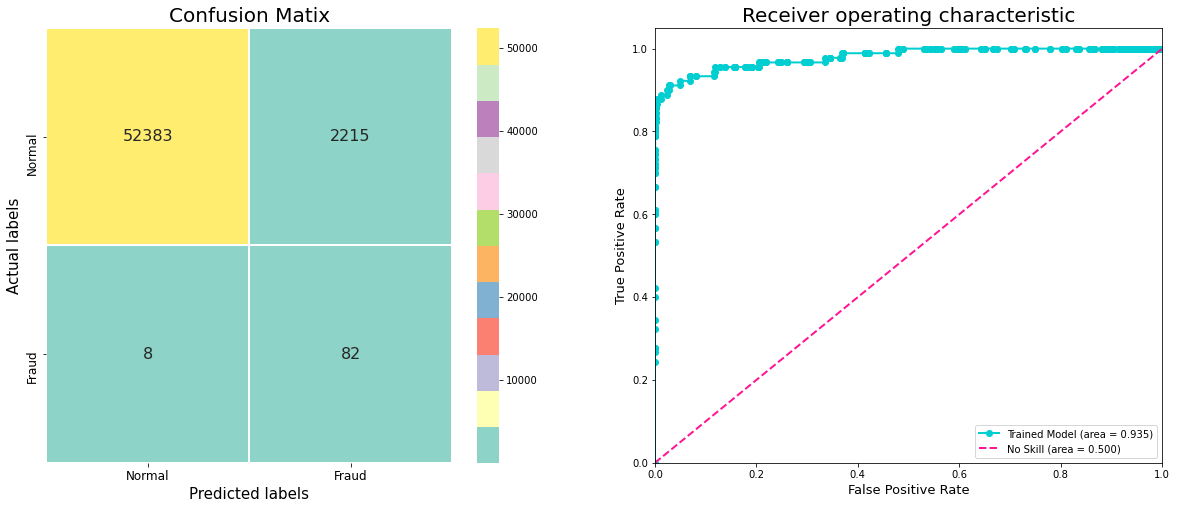

In [74]:
print(classification_report(original_ytest,predictions))

show_metrics(model,original_ytest,predictions)

<h3><font color=red>OBSERVATIONS</font></h3>

&#9658; **ADASYN did work pretty well on the balanced data via oversampling technique as the recall value came out to be 91% .** <br><br>
&#9658; **We get a total of 2223 errors or misclassification**<br><br>
&#9658; **Here we can see that Recall value is pretty high which implies that False Negative is low, Only 8 Fraud Transaction were classified as Normal Transactions**<br><br>
&#9658; **We can observe a very high amount of False positive(2215)**<br><br>
&#9658; **By HIGHER Recall value we identify that the actual fraud transactions which were Incorrectly Predicted as Normal Transaction(i.e. False Negative) is LOW** <br><br>
&#9658; **These are the oversampling techniques used here. We can clearly see that we made progress. Jumping from 0 to 91% recall is pretty good with algorithms that didn't get too complex.**<br><br>
&#9658; **The drawback that follows every single one of these Oversampling techniques is that our happiness may be founded upon overfitting.But since this type of data is itself rare, therefore we can hope that this model did a pretty good job**

<h2><font color=blue> Undersampling</font></h2>

&#9658; **Opposed to oversampling, undersampling changes the proportion between the classes by removing examples from the majority class until we have a more even distribution. There are some methods of using this, we will focus on:**<br>

- **Random Undersampling**


## <font color=blue> Random UnderSampling</font>

&#9658; **As the name suggests, Random Undersampling removes example randomly from the dataset. It follows the same logic as Random Oversampling. Again, we will be using imblearn.** <br>

In [75]:
rus = RandomUnderSampler(sampling_strategy = 0.6, random_state = state)
X_rus, y_rus = rus.fit_resample(original_Xtrain, original_ytrain)
X_rus = pd.DataFrame(X_rus, columns = original_Xtrain.columns)
y_rus = pd.Series(y_rus)

In [76]:
print("Majority class had {} examples and now it has {}.".format(len(original_ytrain[original_ytrain == 0]), len(y_rus[y_rus == 0])))


Majority class had 218392 examples and now it has 601.


We can clearly see that there has been a major cutdown from the original amount of examples. Running a simple Logistic Regression model.

In [77]:
log_reg = LogisticRegression()
model = log_reg.fit(X_ada, y_ada)
predictions = log_reg.predict(original_Xtest)

In [78]:
recall = recall_score(original_ytest,predictions)  # recall refers to the percentage of total relevant results correctly classified by your algorithm
accuracy = accuracy_score(original_ytest,predictions)
f1 = f1_score(original_ytest,predictions)
precision = precision_score(original_ytest,predictions) #Precision means the percentage of your results which are relevant
n_errors = (predictions!=original_ytest).sum()
print("{}:{}".format(model,n_errors))

print("Accuracy: {0:0.2f}%".format(np.mean(accuracy)*100))
print("Precision: {0:0.2f}".format(np.mean(precision)))
print("Recall: {0:0.3f}".format(np.mean(recall)))
print("f1 Score: {0:0.2f}".format(np.mean(f1)))

LogisticRegression():2223
Accuracy: 95.94%
Precision: 0.04
Recall: 0.911
f1 Score: 0.07


              precision    recall  f1-score   support

           0       1.00      0.96      0.98     54598
           1       0.04      0.91      0.07        90

    accuracy                           0.96     54688
   macro avg       0.52      0.94      0.52     54688
weighted avg       1.00      0.96      0.98     54688



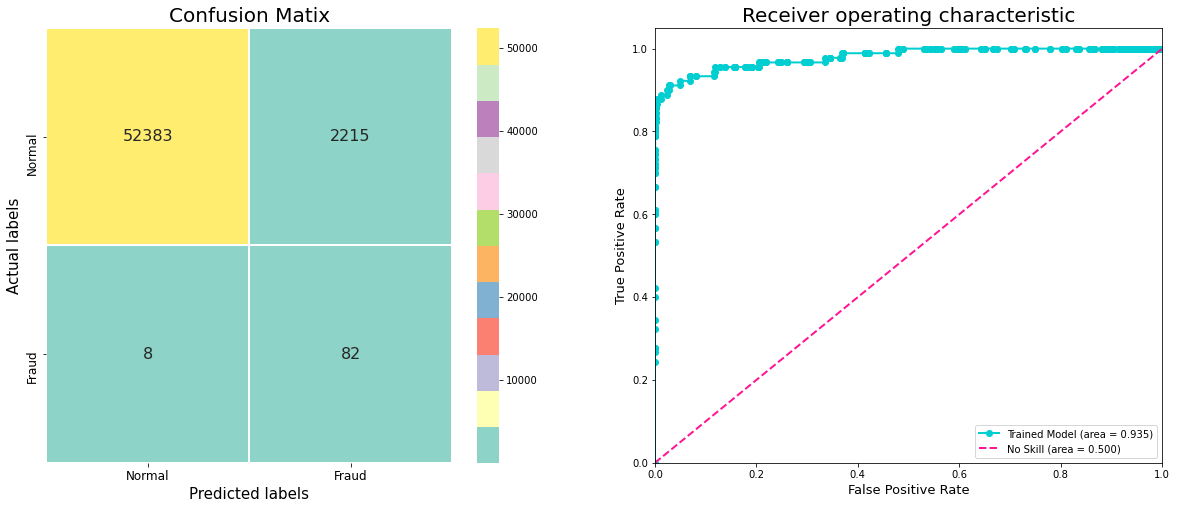

In [79]:
print(classification_report(original_ytest,predictions))

show_metrics(model,original_ytest,predictions)

<h3><font color=red>OBSERVATIONS</font></h3>

&#9658; **Within Random Undersampling we get the same recall value as compared to the ADASYN i.e. 91.1%**<br>
&#9658; **By randomly removing examples, we might be throwing away valuable data. Data that is representative of the real problem that we are trying to solve. We simply do not have any mechanisms that are built in the algorithm to deal with the possible loss of information.**

## <font color=blue> Outlier Detection</font>

&#9658; **Up until now, we've been dealing with the imbalance of our dataset from a perspective of more data. If we get more data, then our lives will be easier.** <br>
&#9658; **When we consider our dataset, the fraud transactions consist less than 1% of total entries. Therefore it is, by definition, an outlier. Therefore, we could apply algorithms that are really good at detecting an outlier and then label its predictions of outliers as fraudulent transactions.**<br>
&#9658; **We'll approach two different algorithms that can do this:-**<br>

- **Isolation Forest Algorithm**
- **Local Outlier Factor Algorithm**<br>

## <font color=blue> Isolation Forest Algorithm</font>

&#9658; **One of the newest techniques to detect anomalies is called Isolation Forests. The algorithm is based on the fact that anomalies are data points that are few and different. As a result of these properties, anomalies are susceptible to a mechanism called isolation. Take a look at the following images, they explain it very well.**<br>

<img src = "https://drive.google.com/uc?id=1UI-N7hF0KOE83hA_X8NTiMfZZbb6cPzf">
 <br>
 
&#9658; **This method is highly useful and is fundamentally different from all existing methods. It introduces the use of isolation as a more effective and efficient means to detect anomalies than the commonly used basic distance and density measures. Moreover, this method is an algorithm with a low linear time complexity and a small memory requirement. It builds a good performing model with a small number of trees using small sub-samples of fixed size, regardless of the size of a data set.**<br><br>

&#9658; **Typical machine learning methods tend to work better when the patterns they try to learn are balanced, meaning the same amount of good and bad behaviors are present in the dataset.**<br><br>

&#9658; **The Isolation Forest algorithm isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. The logic argument goes: isolating anomaly observations is easier because only a few conditions are needed to separate those cases from the normal observations. On the other hand, isolating normal observations require more conditions. Therefore, an anomaly score can be calculated as the number of conditions required to separate a given observation.**<br><br>

&#9658; **The that the algorithm constructs the separation is by first creating isolation trees, or random decision trees. Then, the score is calculated as the path length to isolate the observation.**



In [80]:
important_features = ['Time', 'V1', 'V2', 'V4', 'V6', 'V8', 'V9', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V19', 'Amount']

In [93]:
isf = IsolationForest(n_estimators = 110,max_samples = 'auto',max_features = 15)
model = isf.fit(original_Xtrain[important_features])
predictions = isf.predict(original_Xtest[important_features])
predictions[predictions == 1] = 0
predictions[predictions == -1] = 1
n_errors = (predictions!=original_ytest).sum()


In [94]:
recall = recall_score(original_ytest,predictions)  # recall refers to the percentage of total relevant results correctly classified by your algorithm
accuracy = accuracy_score(original_ytest,predictions)
f1 = f1_score(original_ytest,predictions)
precision = precision_score(original_ytest,predictions) #Precision means the percentage of your results which are relevant

print("{}:{}".format(model,n_errors))

print("Accuracy: {0:0.2f}%".format(np.mean(accuracy)*100))
print("Precision: {0:0.2f}".format(np.mean(precision)))
print("Recall: {0:0.3f}".format(np.mean(recall)))
print("f1 Score: {0:0.2f}".format(np.mean(f1)))

IsolationForest(max_features=15, n_estimators=110):3003
Accuracy: 94.51%
Precision: 0.03
Recall: 0.900
f1 Score: 0.05


In [95]:
print(classification_report(original_ytest,predictions))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     54598
           1       0.03      0.90      0.05        90

    accuracy                           0.95     54688
   macro avg       0.51      0.92      0.51     54688
weighted avg       1.00      0.95      0.97     54688



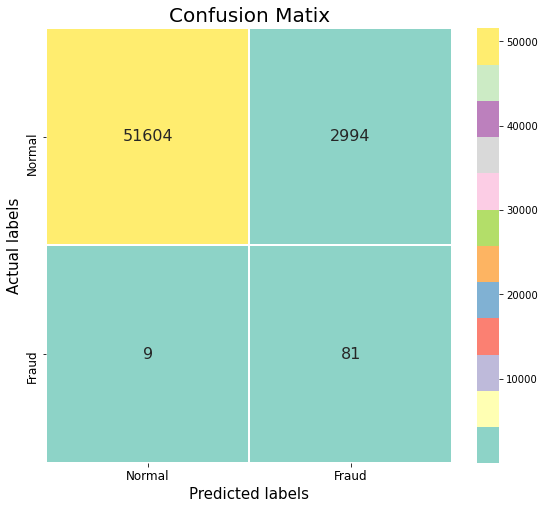

In [96]:
fig = plt.figure(figsize=(20, 8))

    # Confusion matrix
ax = fig.add_subplot(121)
sns.heatmap(confusion_matrix(original_ytest,predictions), annot=True, annot_kws={"size": 16}, fmt='g', 
            cmap='Set3', linewidths=1, linecolor='white')


# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=15);
ax.set_ylabel('Actual labels', fontsize=15); 
ax.set_title("Confusion Matix", fontsize=20) 
ax.xaxis.set_ticklabels(['Normal', 'Fraud'], fontsize=12); 
ax.yaxis.set_ticklabels(['Normal', 'Fraud'], fontsize=12);

<h3><font color=red>OBSERVATIONS</font></h3>

&#9658; **Within Isolation Forest we get the recall value of 90% on an imbalanced dataset**<br>

&#9658; **We get a total of 2994 errors or misclassification**<br><br>
&#9658; **Here we can see that Recall value is pretty high which implies that False Negative is low, Only 9 Fraud Transaction were classified as Normal Transactions**<br><br>
&#9658; **We can observe a very high amount of False positive(2810). We can reduce this further by using neural network to increase the accuracy for detecting fraud and non-fraud transactions **<br><br>
&#9658; **By HIGHER Recall value we identify that the actual fraud transactions which were Incorrectly Predicted as Normal Transaction(i.e. False Negative) is LOW** <br><br>
&#9658; **This was an Outlier Detection techniques used here. We can clearly see that we made progress by increasing the recall value from 43% to 90% on an completely imbalanced data.**<br><br>
